# RL tutor for a simulated student

A simple simulation of an **AI-powered tutor** interacting with a student over a session of 50 questions. The model tracks how the **student's skill evolves**, and how the **AI is rewarded or penalized** based on the difficulty of questions it selects and how much the student improves.

This is **not a reinforcement learning agent (yet)** — it's a controlled simulation that lays the foundation for more advanced AI tutor experiments, including RL-based policy learning.

---

## Motivation

The goal is to understand how an AI tutor could:
- Adaptively select questions of varying difficulty
- Promote student learning without relying too heavily on easy questions
- Receive feedback (rewards) for teaching performance

This mirrors real educational settings, where **over-challenging or under-challenging a student** both lead to poor outcomes.

---

## Simulation Logic

At each time step (question):
- The AI selects a question of either **easy (1)** or **hard (2)** difficulty
- The student attempts the question, with success probability based on current **skill level**
- The student's skill is updated based on success/failure, difficulty, forgetting, and AI behavior
- The AI receives a **reward** for student improvement, and a **penalty** if it overuses easy questions

---

## Student Skill Update Equation

Let:
- `α` = learning rate  
- `β` = forgetting rate  
- `γ` = penalty for repeated easy questions  
- `r` = reward from the current question  
- `d` = difficulty (1 = easy, 2 = hard)

Then the skill is updated as:

$$skill[t+1] = skill[t] + α * (r * d) - β * d - penalty$$


Where:
- `r = 5` if the student got a hard question correct  
- `r = 1` if the student got an easy question correct  
- `r = -1` if the student answered incorrectly  
- `penalty = γ` if the AI gives more than 3 easy questions in a row, otherwise 0

Skill is clamped to be non-negative.

---

## AI Reward Function

The AI receives a reward at each step:
$$
\text{AI\_reward}_t = r - \text{penalty}
$$



This encourages the AI to:
- Push the student to improve
- Avoid "gaming the system" by only giving easy questions

---

## Outputs

- `AI_Tutor_Results.csv`: Logs each question's result, skill level, AI reward
- A line chart that shows:
  - Student skill progression
  - Cumulative AI reward over time

---

## Adjustable Parameters

| Parameter       | Meaning                                      |
|-----------------|----------------------------------------------|
| `alpha`         | Learning rate (how fast the student learns)  |
| `beta`          | Forgetting rate (how fast skill decays)      |
| `gamma`         | Penalty for streaks of easy questions        |
| `num_questions` | Total number of questions in the simulation  |


File saved as AI_Tutor_Results.csv


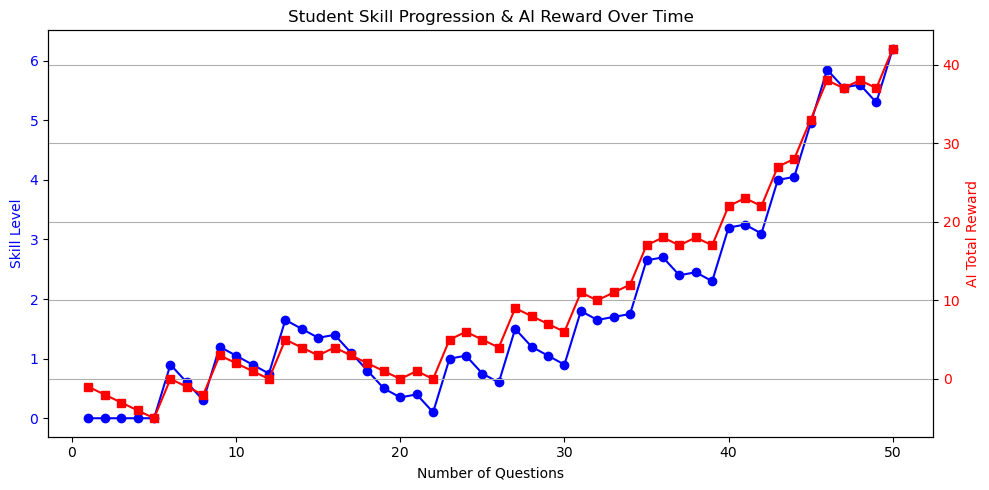

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
alpha = 0.1  # Learning rate (how fast the student learns)
beta = 0.05  # Forgetting rate (how fast skill decays)
gamma = 0.2  # AI penalty for overusing easy questions
num_questions = 50  # Number of questions in the session

# Difficulty scaling
EASY_DIFFICULTY = 1
HARD_DIFFICULTY = 2

# Initialize values
skill_level = 0
AI_reward_total = 0  # Track total reward AI earns

# Track history
skill_history = []
AI_reward_history = []

# Simulate AI tutor
easy_streak = 0  # Counts consecutive easy questions

for _ in range(num_questions):
    # AI selects a question (50% easy, 50% hard for visualization)
    difficulty = np.random.choice([EASY_DIFFICULTY, HARD_DIFFICULTY])
    
    # Student answers correctly based on skill level
    success_chance = 0.3 + (0.1 * skill_level)  # Base success rate + skill influence
    correct = np.random.rand() < success_chance

    # Compute reward for student learning
    reward = 5 if (correct and difficulty == HARD_DIFFICULTY) else (1 if correct else -1)
    
    # Track AI behavior
    if difficulty == EASY_DIFFICULTY:
        easy_streak += 1
    else:
        easy_streak = 0  # Reset if AI picks hard question

    penalty = gamma if easy_streak > 3 else 0  # AI penalty for overusing easy questions

    # Update skill level
    skill_level += alpha * (reward * difficulty) - beta * difficulty - penalty
    skill_level = max(0, skill_level)  # Ensure skill doesn't go negative

    # Compute AI's reward (AI is rewarded for student improvement and good question selection)
    AI_reward = reward - penalty  # AI loses points if it gives too many easy questions
    AI_reward_total += AI_reward

    # Store history for visualization
    skill_history.append(skill_level)
    AI_reward_history.append(AI_reward_total)  # Track cumulative AI reward

# Compute per-step AI reward
AI_reward_per_step = np.diff([0] + AI_reward_history)  # Calculate difference between steps

# Create DataFrame with all results
df_combined = pd.DataFrame({
    "Question #": np.arange(1, num_questions + 1),
    "Skill Level": skill_history,
    "AI Reward Per Step": AI_reward_per_step,
    "AI Total Reward": AI_reward_history
})

# Save the dataset locally
df_combined.to_csv("AI_Tutor_Results.csv", index=False)
print("File saved as AI_Tutor_Results.csv")

# Plot skill progression and AI reward
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot skill level
ax1.set_xlabel("Number of Questions")
ax1.set_ylabel("Skill Level", color='b')
ax1.plot(df_combined["Question #"], df_combined["Skill Level"], marker='o', linestyle='-', color='b', label="Student Skill Level")
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for AI reward
ax2 = ax1.twinx()
ax2.set_ylabel("AI Total Reward", color='r')
ax2.plot(df_combined["Question #"], df_combined["AI Total Reward"], marker='s', linestyle='-', color='r', label="AI Total Reward")
ax2.tick_params(axis='y', labelcolor='r')

# Title and legends
plt.title("Student Skill Progression & AI Reward Over Time")
fig.tight_layout()
plt.grid()
plt.show()